<a href="https://colab.research.google.com/github/inuwamobarak/flux-image-generation/blob/main/A_Guide_to_Image_Generation_Quantization_Flux_on_8GB_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq git+https://github.com/huggingface/diffusers@main
!pip install -Uq git+https://github.com/huggingface/transformers@main
!pip install -Uq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 9.2 MB/s eta 0:00:00


In [5]:
import diffusers
import transformers
import bitsandbytes as bnb
from diffusers import FluxPipeline, FluxTransformer2DModel
from transformers import T5EncoderModel
import torch
import gc

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_peak_memory_stats()


def bytes_to_giga_bytes(bytes):
    return bytes / 1024 / 1024 / 1024

flush()

# Checkpoints
ckpt_id = "black-forest-labs/FLUX.1-dev"
ckpt_4bit_id = "hf-internal-testing/flux.1-dev-nf4-pkg"
prompt = "a cute dog in paris photoshoot"


text_encoder_2_4bit = T5EncoderModel.from_pretrained(
    ckpt_4bit_id,
    subfolder="text_encoder_2",
)

pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder_2=text_encoder_2_4bit,
    transformer=None,
    vae=None,
    torch_dtype=torch.float16,
)
pipeline.enable_model_cpu_offload()


with torch.no_grad():
    print("Encoding prompts.")
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
        prompt=prompt, prompt_2=None, max_sequence_length=256
    )


del pipeline
flush()


transformer_4bit = FluxTransformer2DModel.from_pretrained(ckpt_4bit_id, subfolder="transformer")
pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder=None,
    text_encoder_2=None,
    tokenizer=None,
    tokenizer_2=None,
    transformer=transformer_4bit,
    torch_dtype=torch.float16,
)
pipeline.enable_model_cpu_offload()

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


text_encoder_2/config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/6.33G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer_2/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Encoding prompts.


transformer/config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/6.70G [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Running denoising.


  0%|          | 0/50 [00:00<?, ?it/s]

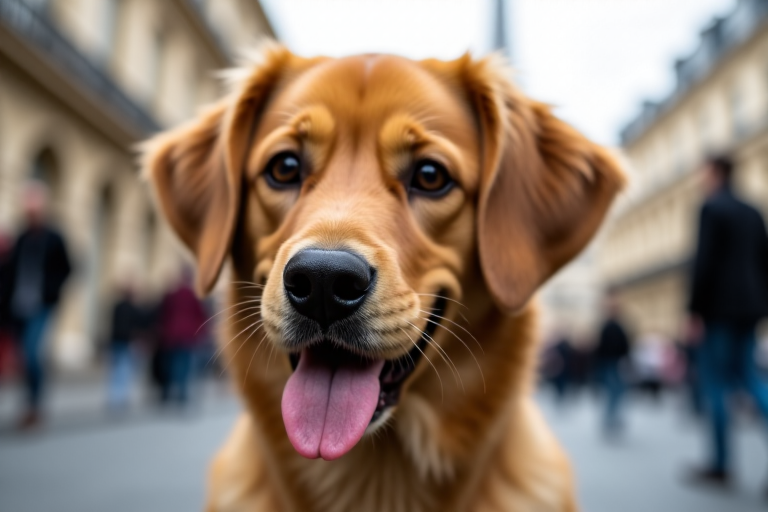

In [7]:
print("Running denoising.")
height, width = 512, 768
images = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=50,
    guidance_scale=5.5,
    height=height,
    width=width,
    output_type="pil",
).images

# Display the image
images[0]